In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F
from scipy.fft import fft
from collections import Counter

# 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
fft_length = segment_length // 2
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"

In [2]:
from scipy.signal import stft

def segment_and_stft(signal):
    segments = []
    for start in range(0, len(signal) - segment_length, segment_length):
        segment = signal[start:start+segment_length]
        _, _, Zxx = stft(segment, fs=sampling_rate, nperseg=256)
        spectrogram = np.abs(Zxx)  # shape: (freq, time)
        segments.append(spectrogram)
    return np.array(segments)


In [3]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue
        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()
        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()
        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)
        stft_segments = segment_and_stft(ecg_signal)
        max_segments = len(stft_segments)
        usable_len = min(len(label_seq), max_segments)
        all_segments.extend(stft_segments[:usable_len])
        all_labels.extend(label_seq[:usable_len])
    X = torch.tensor(np.expand_dims(np.array(all_segments), axis=1), dtype=torch.float32)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y

In [4]:
def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue
        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue
        y_np = y.numpy()
        X_np = X.numpy()
        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue
        min_count = min(label_counts.values())
        indices = []
        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)
        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue
        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])
        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")
    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")
    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all

In [5]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))
X_test, y_test = load_data_from_sn(list(range(124, 154)))

✅ SN001 처리 완료: 클래스당 23개


✅ SN002 처리 완료: 클래스당 82개


✅ SN003 처리 완료: 클래스당 150개


✅ SN004 처리 완료: 클래스당 64개


✅ SN005 처리 완료: 클래스당 127개


✅ SN006 처리 완료: 클래스당 65개


✅ SN007 처리 완료: 클래스당 67개


✅ SN008 처리 완료: 클래스당 39개


✅ SN009 처리 완료: 클래스당 91개


✅ SN010 처리 완료: 클래스당 101개


✅ SN011 처리 완료: 클래스당 37개


✅ SN012 처리 완료: 클래스당 184개


✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀


✅ SN015 처리 완료: 클래스당 102개


✅ SN016 처리 완료: 클래스당 24개


✅ SN017 처리 완료: 클래스당 96개


✅ SN018 처리 완료: 클래스당 19개


✅ SN019 처리 완료: 클래스당 72개


✅ SN020 처리 완료: 클래스당 67개


✅ SN021 처리 완료: 클래스당 156개


✅ SN022 처리 완료: 클래스당 115개


✅ SN023 처리 완료: 클래스당 74개


✅ SN024 처리 완료: 클래스당 70개


✅ SN025 처리 완료: 클래스당 106개


✅ SN026 처리 완료: 클래스당 127개


✅ SN027 처리 완료: 클래스당 19개


✅ SN028 처리 완료: 클래스당 136개


✅ SN029 처리 완료: 클래스당 59개


✅ SN030 처리 완료: 클래스당 108개


✅ SN031 처리 완료: 클래스당 74개


✅ SN032 처리 완료: 클래스당 133개
✅ SN033 처리 완료: 클래스당 47개


✅ SN034 처리 완료: 클래스당 75개


✅ SN035 처리 완료: 클래스당 108개


✅ SN036 처리 완료: 클래스당 87개


✅ SN037 처리 완료: 클래스당 65개


✅ SN038 처리 완료: 클래스당 61개


✅ SN039 처리 완료: 클래스당 108개


✅ SN040 처리 완료: 클래스당 62개


✅ SN041 처리 완료: 클래스당 130개


✅ SN042 처리 완료: 클래스당 148개


✅ SN043 처리 완료: 클래스당 56개


✅ SN044 처리 완료: 클래스당 55개


✅ SN045 처리 완료: 클래스당 129개


✅ SN046 처리 완료: 클래스당 49개


✅ SN047 처리 완료: 클래스당 125개


✅ SN048 처리 완료: 클래스당 146개


✅ SN049 처리 완료: 클래스당 41개


✅ SN050 처리 완료: 클래스당 25개


✅ SN051 처리 완료: 클래스당 84개


✅ SN052 처리 완료: 클래스당 59개


✅ SN053 처리 완료: 클래스당 163개


✅ SN054 처리 완료: 클래스당 28개


✅ SN055 처리 완료: 클래스당 115개


✅ SN056 처리 완료: 클래스당 64개


✅ SN057 처리 완료: 클래스당 7개


✅ SN058 처리 완료: 클래스당 103개


✅ SN059 처리 완료: 클래스당 138개


✅ SN060 처리 완료: 클래스당 46개


✅ SN061 처리 완료: 클래스당 150개


✅ SN062 처리 완료: 클래스당 5개


✅ SN063 처리 완료: 클래스당 139개
❌ 파일 없음: SN064
⚠️ SN064: 라벨 없음 → 건너뜀


✅ SN065 처리 완료: 클래스당 65개


✅ SN066 처리 완료: 클래스당 88개


✅ SN067 처리 완료: 클래스당 123개


✅ SN068 처리 완료: 클래스당 116개


✅ SN069 처리 완료: 클래스당 69개


✅ SN070 처리 완료: 클래스당 35개


✅ SN071 처리 완료: 클래스당 16개


✅ SN072 처리 완료: 클래스당 115개


✅ SN073 처리 완료: 클래스당 39개


✅ SN074 처리 완료: 클래스당 37개


✅ SN075 처리 완료: 클래스당 186개


✅ SN076 처리 완료: 클래스당 56개


✅ SN077 처리 완료: 클래스당 85개


✅ SN078 처리 완료: 클래스당 55개


✅ SN079 처리 완료: 클래스당 61개


✅ SN080 처리 완료: 클래스당 28개


✅ SN081 처리 완료: 클래스당 2개


✅ SN082 처리 완료: 클래스당 37개


✅ SN083 처리 완료: 클래스당 136개


✅ SN084 처리 완료: 클래스당 27개


✅ SN085 처리 완료: 클래스당 111개


✅ SN086 처리 완료: 클래스당 110개


✅ SN087 처리 완료: 클래스당 34개


✅ SN088 처리 완료: 클래스당 125개


✅ SN089 처리 완료: 클래스당 85개


✅ SN090 처리 완료: 클래스당 76개


✅ SN091 처리 완료: 클래스당 40개


✅ SN092 처리 완료: 클래스당 93개


✅ SN093 처리 완료: 클래스당 71개


✅ SN094 처리 완료: 클래스당 79개


✅ SN095 처리 완료: 클래스당 50개


✅ SN096 처리 완료: 클래스당 55개


✅ SN097 처리 완료: 클래스당 46개


✅ SN098 처리 완료: 클래스당 80개


✅ SN099 처리 완료: 클래스당 56개


✅ SN100 처리 완료: 클래스당 81개


✅ SN101 처리 완료: 클래스당 120개


✅ SN102 처리 완료: 클래스당 36개


✅ SN103 처리 완료: 클래스당 70개


✅ SN104 처리 완료: 클래스당 104개


✅ SN105 처리 완료: 클래스당 34개


✅ SN106 처리 완료: 클래스당 53개


✅ SN107 처리 완료: 클래스당 77개


✅ SN108 처리 완료: 클래스당 50개


✅ SN109 처리 완료: 클래스당 48개


✅ SN110 처리 완료: 클래스당 96개


✅ SN111 처리 완료: 클래스당 135개


✅ SN112 처리 완료: 클래스당 83개


✅ SN113 처리 완료: 클래스당 85개


✅ SN114 처리 완료: 클래스당 73개


✅ SN115 처리 완료: 클래스당 98개


✅ SN116 처리 완료: 클래스당 43개


✅ SN117 처리 완료: 클래스당 108개


✅ SN118 처리 완료: 클래스당 114개


✅ SN119 처리 완료: 클래스당 89개


✅ SN120 처리 완료: 클래스당 29개


✅ SN121 처리 완료: 클래스당 61개


✅ SN122 처리 완료: 클래스당 66개


✅ SN123 처리 완료: 클래스당 98개


❌ 파일 없음: SN135


In [6]:
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d((2, 2))

        self.flatten_size = 64 * (129 // 8) * (61 // 8)  # 풀링 3회 후 크기 추정
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [7]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(50):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()
    train_acc = 100 * correct / total
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")



📘 Epoch 1 | Train Loss: 1179.8847 | Train Acc: 36.64% | Val Loss: 1.6526 | Val Acc: 37.45%


📘 Epoch 2 | Train Loss: 1143.5699 | Train Acc: 39.39% | Val Loss: 1.4454 | Val Acc: 38.16%


📘 Epoch 3 | Train Loss: 1117.4900 | Train Acc: 41.56% | Val Loss: 1.5280 | Val Acc: 37.80%


📘 Epoch 4 | Train Loss: 1093.3738 | Train Acc: 43.34% | Val Loss: 1.5001 | Val Acc: 38.13%


📘 Epoch 5 | Train Loss: 1069.7174 | Train Acc: 45.75% | Val Loss: 1.4533 | Val Acc: 38.69%


📘 Epoch 6 | Train Loss: 1041.8577 | Train Acc: 47.66% | Val Loss: 1.6239 | Val Acc: 38.27%


📘 Epoch 7 | Train Loss: 1011.5440 | Train Acc: 49.98% | Val Loss: 1.5878 | Val Acc: 39.69%


📘 Epoch 8 | Train Loss: 987.3903 | Train Acc: 51.94% | Val Loss: 1.7915 | Val Acc: 38.83%


📘 Epoch 9 | Train Loss: 961.8336 | Train Acc: 53.26% | Val Loss: 2.0048 | Val Acc: 36.63%


📘 Epoch 10 | Train Loss: 934.4221 | Train Acc: 54.99% | Val Loss: 1.7426 | Val Acc: 38.35%


📘 Epoch 11 | Train Loss: 913.1195 | Train Acc: 55.96% | Val Loss: 2.4247 | Val Acc: 35.86%


📘 Epoch 12 | Train Loss: 886.9645 | Train Acc: 57.52% | Val Loss: 2.6033 | Val Acc: 34.39%


📘 Epoch 13 | Train Loss: 867.1142 | Train Acc: 58.74% | Val Loss: 1.8578 | Val Acc: 38.75%


📘 Epoch 14 | Train Loss: 843.5479 | Train Acc: 59.84% | Val Loss: 2.1373 | Val Acc: 37.42%


📘 Epoch 15 | Train Loss: 824.6031 | Train Acc: 61.03% | Val Loss: 2.1232 | Val Acc: 38.46%


📘 Epoch 16 | Train Loss: 806.3544 | Train Acc: 62.04% | Val Loss: 1.8907 | Val Acc: 38.91%


📘 Epoch 17 | Train Loss: 786.3239 | Train Acc: 63.11% | Val Loss: 2.3133 | Val Acc: 37.20%


📘 Epoch 18 | Train Loss: 764.8343 | Train Acc: 64.25% | Val Loss: 2.5521 | Val Acc: 35.32%


📘 Epoch 19 | Train Loss: 750.6232 | Train Acc: 65.10% | Val Loss: 1.8937 | Val Acc: 38.25%


📘 Epoch 20 | Train Loss: 736.3463 | Train Acc: 66.03% | Val Loss: 1.9980 | Val Acc: 37.83%


📘 Epoch 21 | Train Loss: 715.7968 | Train Acc: 67.02% | Val Loss: 2.2927 | Val Acc: 35.82%


📘 Epoch 22 | Train Loss: 701.8959 | Train Acc: 67.74% | Val Loss: 3.4396 | Val Acc: 33.88%


📘 Epoch 23 | Train Loss: 683.1010 | Train Acc: 68.86% | Val Loss: 3.2938 | Val Acc: 33.11%


📘 Epoch 24 | Train Loss: 668.5519 | Train Acc: 69.58% | Val Loss: 3.4596 | Val Acc: 33.41%


📘 Epoch 25 | Train Loss: 658.4387 | Train Acc: 70.28% | Val Loss: 2.5809 | Val Acc: 34.92%


📘 Epoch 26 | Train Loss: 643.2959 | Train Acc: 70.52% | Val Loss: 2.2323 | Val Acc: 38.75%


📘 Epoch 27 | Train Loss: 619.5131 | Train Acc: 71.92% | Val Loss: 2.7834 | Val Acc: 36.93%


📘 Epoch 28 | Train Loss: 610.9743 | Train Acc: 72.36% | Val Loss: 1.9463 | Val Acc: 38.69%


📘 Epoch 29 | Train Loss: 593.4943 | Train Acc: 73.55% | Val Loss: 3.2759 | Val Acc: 34.09%


📘 Epoch 30 | Train Loss: 583.7871 | Train Acc: 73.88% | Val Loss: 3.7164 | Val Acc: 32.26%


📘 Epoch 31 | Train Loss: 564.2875 | Train Acc: 74.87% | Val Loss: 2.7358 | Val Acc: 37.26%


📘 Epoch 32 | Train Loss: 560.8797 | Train Acc: 74.99% | Val Loss: 4.3589 | Val Acc: 31.44%


📘 Epoch 33 | Train Loss: 544.9653 | Train Acc: 75.81% | Val Loss: 3.3090 | Val Acc: 32.26%


📘 Epoch 34 | Train Loss: 523.7302 | Train Acc: 76.82% | Val Loss: 2.5532 | Val Acc: 38.43%


📘 Epoch 35 | Train Loss: 523.3385 | Train Acc: 76.97% | Val Loss: 2.7869 | Val Acc: 35.01%


📘 Epoch 36 | Train Loss: 508.9673 | Train Acc: 77.53% | Val Loss: 2.8348 | Val Acc: 37.04%


📘 Epoch 37 | Train Loss: 487.1305 | Train Acc: 78.86% | Val Loss: 2.9749 | Val Acc: 35.94%


📘 Epoch 38 | Train Loss: 483.3176 | Train Acc: 78.55% | Val Loss: 2.7532 | Val Acc: 38.16%


📘 Epoch 39 | Train Loss: 477.2937 | Train Acc: 79.30% | Val Loss: 3.0452 | Val Acc: 36.88%


📘 Epoch 40 | Train Loss: 457.3078 | Train Acc: 79.96% | Val Loss: 3.4545 | Val Acc: 35.90%


📘 Epoch 41 | Train Loss: 448.1881 | Train Acc: 80.62% | Val Loss: 3.2999 | Val Acc: 36.07%


📘 Epoch 42 | Train Loss: 442.2262 | Train Acc: 80.59% | Val Loss: 5.9441 | Val Acc: 30.48%


📘 Epoch 43 | Train Loss: 428.4012 | Train Acc: 81.42% | Val Loss: 3.5052 | Val Acc: 35.54%


📘 Epoch 44 | Train Loss: 412.7659 | Train Acc: 82.10% | Val Loss: 2.9308 | Val Acc: 39.51%


📘 Epoch 45 | Train Loss: 414.3058 | Train Acc: 82.07% | Val Loss: 3.8232 | Val Acc: 31.77%


📘 Epoch 46 | Train Loss: 398.2974 | Train Acc: 82.81% | Val Loss: 3.8914 | Val Acc: 34.78%


📘 Epoch 47 | Train Loss: 384.3429 | Train Acc: 83.31% | Val Loss: 3.5955 | Val Acc: 35.23%


📘 Epoch 48 | Train Loss: 374.6240 | Train Acc: 84.19% | Val Loss: 3.6570 | Val Acc: 37.07%


📘 Epoch 49 | Train Loss: 370.6826 | Train Acc: 84.08% | Val Loss: 3.1785 | Val Acc: 36.92%


📘 Epoch 50 | Train Loss: 360.5221 | Train Acc: 84.75% | Val Loss: 3.1096 | Val Acc: 36.92%


In [8]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


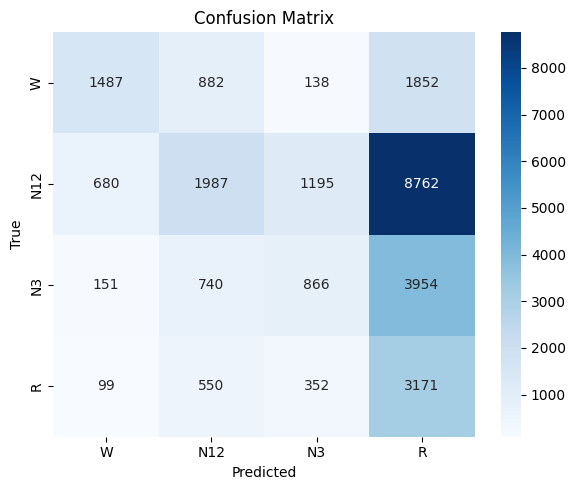

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.62      0.34      0.44      4359
         N12       0.48      0.16      0.24     12624
          N3       0.34      0.15      0.21      5711
           R       0.18      0.76      0.29      4172

    accuracy                           0.28     26866
   macro avg       0.40      0.35      0.29     26866
weighted avg       0.42      0.28      0.27     26866



In [9]:
labels = ['W', 'N12', 'N3', 'R']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
